In [2]:
import os
import numpy as np
import time
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
import sys
from itertools import combinations, permutations

from skimage import io, color
from skimage.transform import resize
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, classification_report

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F

import torchvision.transforms.functional as TF
from torchvision.models.segmentation import fcn_resnet50
from torchsummary import summary
from torchvision.models import resnet50
from torchvision import models

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
class EarDataset(Dataset):

    def __init__(self, path, ids, train=False, id_features=False):
        self.path = path  # "/content/drive/MyDrive/AWEDataset/awe"
        self.train = train
        self.ids = ids
        self.id_features = id_features
        _, folders, _ = next(os.walk(path))

        ## we have to get two images from same person and one from somebody else for one training sample

        self.all = np.array([])
        self.pairs = []#np.array([])
        for f in folders:
            files = list(sorted(os.listdir(os.path.join(path, f))))
            del files[files.index("annotations.json")]

            for i in range(len(files)):
                files[i] = os.path.join(f,files[i])

            files = [x for x in files if x in self.ids]  ## separate test and train i guess
                
            self.all = np.append(self.all, files)
            
            for p in list(permutations(files, 2)):
                self.pairs.append(p)

        self.diff = []
        
        for pair in self.pairs:
            possible = [fx for ix,fx in enumerate(self.all) if fx[:3]!=pair[0][:3]]
            c = np.random.randint(0,len(possible))
            self.diff.append(possible[c])
        
    def __len__(self):
        if self.id_features:
            return len(self.all)
        return len(self.pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        tf_compose = transforms.Compose([transforms.ToTensor(),
                                         transforms.Resize((160,84)),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

        if self.id_features:
            obj = self.all[idx]
            id_obj = obj[:3]

            img_name = os.path.join(self.path, obj)
            img = io.imread(img_name)

            if len(img.shape) == 2:
                img = color.gray2rgb(img)
            elif img.shape[2] == 4:
                img = img[:,:,:3]

            img = tf_compose(img)
            img = img.type(torch.FloatTensor)

            return img, int(id_obj)-1

        pair = self.pairs[idx]
        other = self.diff[idx]

        id_pos = pair[0][:3]
        id_neg = other[:3]

        imgs = {}
        
        img_name1 = os.path.join(self.path, pair[0])
        img_name2 = os.path.join(self.path, pair[1])
        img_other = os.path.join(self.path, other)

        imgs["pair1"] = io.imread(img_name1) 
        imgs["pair2"] = io.imread(img_name2)
        imgs["other"] = io.imread(img_other)

        ## for images in dataset that are grayscale or have alpha channel...
        for k in imgs.keys():
            if len(imgs[k].shape) == 2:
                imgs[k] = color.gray2rgb(imgs[k])
            elif imgs[k].shape[2] == 4:
                imgs[k] = imgs[k][:,:,:3]

            imgs[k] = tf_compose(imgs[k])
            imgs[k] = imgs[k].type(torch.FloatTensor)
       
        return imgs["pair1"], imgs["pair2"], imgs["other"], int(id_pos)-1, int(id_neg)-1

In [4]:
import csv
ids = {"train_ids":[], "test_ids":[]}

with open("/content/drive/MyDrive/AWEDataset/awe/awe-translation.csv", newline='') as csvfile:
    r = csv.reader(csvfile, delimiter=',')
    for row in r:
        if row[0][:5]=="train":
            # if int(row[2]) not in ids["train_ids"]:
            #     ids["train_ids"][int(row[2])] = []
            # ids["train_ids"][int(row[2])].append(row[1])
            ids["train_ids"].append(row[1])
        elif row[0][:4]=="test":
            ids["test_ids"].append(row[1])
        else:
            print(row)

print(len(ids["train_ids"]), len(ids["test_ids"]))
print(ids["test_ids"])

['AWE-Full image path', 'AWE image path', 'Subject ID']
750 250
['011/07.png', '011/08.png', '011/09.png', '001/03.png', '012/08.png', '012/09.png', '002/01.png', '012/10.png', '002/02.png', '013/03.png', '014/02.png', '014/10.png', '015/02.png', '015/07.png', '015/03.png', '016/07.png', '016/08.png', '016/09.png', '017/07.png', '017/08.png', '017/09.png', '018/08.png', '018/09.png', '018/10.png', '019/03.png', '020/01.png', '020/02.png', '021/04.png', '021/05.png', '021/02.png', '022/07.png', '022/08.png', '022/09.png', '023/07.png', '023/08.png', '023/09.png', '003/04.png', '024/08.png', '024/09.png', '003/05.png', '024/10.png', '003/06.png', '025/03.png', '026/01.png', '026/04.png', '027/04.png', '027/05.png', '027/01.png', '028/07.png', '028/08.png', '028/02.png', '029/02.png', '029/09.png', '029/10.png', '030/09.png', '030/10.png', '030/02.png', '031/03.png', '032/01.png', '032/04.png', '033/05.png', '033/01.png', '033/06.png', '034/01.png', '034/08.png', '034/02.png', '035/06.png

In [5]:
def get_model(device, path_model = None, train = False, num_features = 128, num_classes=100):

    class Model(nn.Module):
        def __init__(self, num_features, num_classes):
            super(Model, self).__init__()
            self.model = models.resnet50(pretrained=True)
            ft = self.model.fc.in_features
            self.model.fc = nn.Linear(ft, num_features)
            
            self.fc1 = nn.Linear(num_features, num_features*4)
            self.fc2 = nn.Linear(num_features*4, num_features*8)
            self.fc3 = nn.Linear(num_features*8, num_features*4)
            self.fc4 = nn.Linear(num_features*4, num_classes)

            self.dropout1 = nn.Dropout(0.5)
            self.dropout2 = nn.Dropout(0.5)
            
        def forward(self, x):
            x = self.model(x)
            y = F.relu(self.fc1(x))
            #y = self.dropout1(y)
            y = F.relu(self.fc2(y))
            #y = self.dropout2(y)
            y = F.relu(self.fc3(y))
            y = self.fc4(y)
            return x, y

    model = Model(num_features, num_classes)

    if path_model:
        print("loading model...")

        checkpoint = torch.load(path_model, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])

        if train:
            model.to(device)
            optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            epoch_start = checkpoint['epoch']

            return model, optimizer, epoch_start

    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    epoch_start = 0

    return model, optimizer, epoch_start

#summary(model, input_size=(3,160,84))

EPOCH 0:
1236it [02:59,  6.89it/s]
TRAIN: loss: 0.220759, acc: 0.058
--------------------------------------------------------------------------------
EPOCH 1:
1236it [02:57,  6.98it/s]
TRAIN: loss: 0.097608, acc: 0.174
Saving model...
--------------------------------------------------------------------------------
EPOCH 2:
1236it [02:57,  6.97it/s]
TRAIN: loss: 0.032552, acc: 0.413
Saving model...
--------------------------------------------------------------------------------
EPOCH 3:
1236it [02:57,  6.98it/s]
TRAIN: loss: 0.009548, acc: 0.620
Saving model...
--------------------------------------------------------------------------------
EPOCH 4:
1236it [02:55,  7.04it/s]
TRAIN: loss: 0.003208, acc: 0.789
Saving model...
--------------------------------------------------------------------------------
EPOCH 5:
1236it [02:54,  7.07it/s]
TRAIN: loss: 0.000637, acc: 0.880
Saving model...
--------------------------------------------------------------------------------
EPOCH 6:
1236it [02:

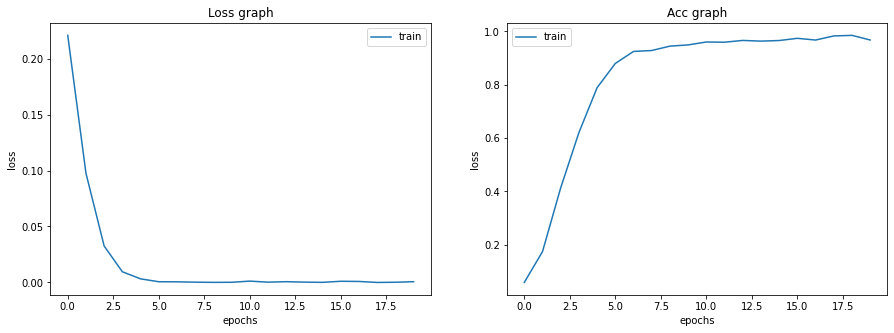

In [14]:
def train(device, train_set, model, optimizer, epoch_start, path_model_save, batch_size=8, num_epochs=1):

    dataloader_train = DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers=4)

    min_loss = 0  # valid : (min_loss, count_since_min_loss)
    loss_log = {"train": np.array([]), "valid": np.array([])}
    # acc_log = {"train": np.array([]), "valid": np.array([])}

    criterion = nn.TripletMarginLoss(margin=0.2, p=2)
    criteriony = nn.CrossEntropyLoss()
    
    graph_loss = {"train": np.array([]), "valid": np.array([])}
    graph_acc = {"train": np.array([]), "valid": np.array([])}

    t1 = time.time()
    for epoch in range(num_epochs):
        print(f"EPOCH {epoch}:")
        t2 = time.time()

        ### TRAIN
        ys = []
        tags = []

        model.train()
        len_tr = int(len(train_set) / batch_size)

        for i, batch in tqdm(enumerate(dataloader_train), total=len_tr, position=0, leave=True, file=sys.stdout, ascii=True):
            pair1, pair2, other, tag, tag_other = batch
            pair1 = pair1.to(device)
            pair2 = pair2.to(device)
            other = other.to(device)

            out1, y1 = model(pair1)
            out2, y2 = model(pair2)
            out3, y3 = model(other)

            loss = criterion(out1.float(), out2.float(), out3.float())
            lossy1 = criteriony(y1.float(), tag.to(device))
            # lossy2 = criteriony(y2.float(), tag.to(device))
            # lossy3 = criteriony(y3.float(), tag_other.to(device))

            loss.backward(retain_graph=True)
            lossy1.backward(retain_graph=True)
            # lossy2.backward(retain_graph=True)
            # lossy3.backward(retain_graph=True)
            optimizer.step()
            optimizer.zero_grad()
            
            loss_log["train"] = np.append(loss_log["train"], loss.cpu().detach().numpy().squeeze())
            out = out1.float().detach().cpu().numpy()

            ys.append(np.argmax(y1.float().detach().cpu().numpy(), axis=1))
            # ys.append(np.argmax(y2.float().detach().cpu().numpy(), axis=1))
            # ys.append(np.argmax(y3.float().detach().cpu().numpy(), axis=1))

            tags.append(tag)
            # tags.append(tag)
            # tags.append(tag_other)

        avg_loss_tr = np.mean(loss_log["train"][-len_tr:])
        avg_acc_tr = accuracy_score(np.concatenate(tags, axis=0), np.concatenate(ys, axis=0))

        graph_loss["train"] = np.append(graph_loss["train"], avg_loss_tr)
        graph_acc["train"] = np.append(graph_acc["train"], avg_acc_tr)

        t3 = time.time()
        print(f"TRAIN: loss: {avg_loss_tr:.6f}, acc: {avg_acc_tr:.3f}")

        if min_loss == 0:
            min_loss = avg_loss_tr

        elif avg_loss_tr < min_loss:
            min_loss = avg_loss_tr
            
            torch.save({'epoch': epoch + epoch_start, 
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': avg_loss_tr
                        }, path_model_save)
            print("Saving model...")

        print("-"*80)

    t5 = time.time()
    print(f"Elapsed time: {(t5-t1)/60} min")
    return graph_loss, graph_acc

# dataset = EarDataset(path="/content/drive/MyDrive/AWEDataset/awe", ids = ids["train_ids"])

# #model, opt, es = get_model(device, path_model="/content/drive/MyDrive/sb-models/model-xy-3.pt", train=True)
# model, opt, es = get_model(device, train=True)
# graph_loss, graph_acc = train(device, dataset, model = model, optimizer=opt, epoch_start=es, path_model_save="/content/drive/MyDrive/sb-models/model-xy-one.pt", batch_size=4, num_epochs=20)

# plt.figure(figsize=(15,5))
# plt.subplot(1, 2, 1)
# plt.title("Loss graph")
# plt.plot(graph_loss["train"], label = "train")
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.title("Acc graph")
# plt.plot(graph_acc["train"], label = "train")
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.legend()


loading model...
100%|##########| 442/442 [02:11<00:00,  3.35it/s]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


acc top1: 0.38687782805429866, acc 5:0.6108597285067874, rec:0.38687782805429866, pre:0.6787330316742082
Top k acc: [0.38687782805429866, 0.497737556561086, 0.5316742081447964, 0.5904977375565611, 0.6108597285067874, 0.6334841628959276, 0.6493212669683258, 0.6832579185520362, 0.7126696832579186, 0.7194570135746606, 0.7352941176470589, 0.7398190045248869, 0.753393665158371, 0.7624434389140271, 0.7647058823529411, 0.7669683257918553, 0.7805429864253394, 0.7941176470588235, 0.7941176470588235, 0.7986425339366516, 0.8076923076923077, 0.8257918552036199, 0.8257918552036199, 0.834841628959276, 0.834841628959276, 0.8529411764705882, 0.8665158371040724, 0.8710407239819005, 0.8755656108597285, 0.8755656108597285, 0.8755656108597285, 0.8755656108597285, 0.8823529411764706, 0.8959276018099548, 0.9004524886877828, 0.9049773755656109, 0.9049773755656109, 0.9049773755656109, 0.9095022624434389, 0.9095022624434389, 0.920814479638009, 0.9253393665158371, 0.9253393665158371, 0.9253393665158371, 0.92533

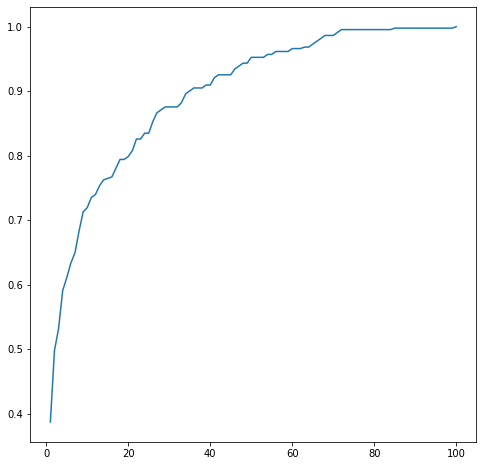

In [7]:
def test(device, dataset, model, top_k=1):

    dataloader = DataLoader(dataset, batch_size = 1, shuffle = False, num_workers=4)

    model.eval()
    # metrics = {"iou": [], "pre": [], "rec": []}

    criterion = nn.TripletMarginLoss(margin=0.2, p=2)
    criteriony = nn.CrossEntropyLoss()

    dist = {"pos":[], "neg":[], "diff":[]}
    #guesses = {"all":[], "avg":[]}
    guesses = {i+1:[] for i in range(top_k)}
    losses = []
    tags = []
    outs = []

    for j, batch in tqdm(enumerate(dataloader), total=len(dataset), position=0, leave=True, file=sys.stdout, ascii=True):
        pair1, pair2, other, pos_id, neg_id = batch
        pair1 = pair1.to(device)
        pair2 = pair2.to(device)
        other = other.to(device)

        with torch.no_grad():
            out1, y1 = model(pair1)
            out2, y2 = model(pair2)
            out3, y3 = model(other)

        loss = criterion(out1.float(), out2.float(), out3.float())
        lossy1 = criteriony(y1.float(), pos_id.to(device))


        out = {"out1":out1.detach().cpu().numpy(), "out2":out2.detach().cpu().numpy(), "other": out3.detach().cpu().numpy()}

        dist_pos = np.square(np.linalg.norm(out["out1"]-out["out2"]))
        dist_neg = np.square(np.linalg.norm(out["out1"]-out["other"]))

        dist["pos"].append(dist_pos)
        dist["neg"].append(dist_neg)
        dist["diff"].append(dist_neg-dist_pos)

        y = {x:xx.float().detach().cpu().numpy() for x, xx in enumerate([y1, y2, y3])}

        [outs.append(np.argmax(y[k], axis=1)) for k in range(3)]

        # for xx, tag in zip(list(range(3)), [pos_id, pos_id, neg_id]):
        for xx, tag in zip(list(range(1)), [pos_id]):
            cand = [np.where(y[xx][0]==x)[0][0] for x in sorted(y[xx][0], reverse=True)[:top_k+1]]

            for i in range(top_k):
                guess = tag if tag in cand[:i+1] else 0

                guesses[i+1].append(guess)

        losses.append(loss.detach().cpu().numpy())

        tags.append(pos_id)
            

    acc = [accuracy_score(tags, guesses[i+1]) for i in range(top_k)]
    rec = [recall_score(tags, guesses[i+1], labels=list(range(100)), average="weighted") for i in range(top_k)]
    pre = [precision_score(tags, guesses[i+1], labels=list(range(100)), average="weighted") for i in range(top_k)]

    print(f"acc top1: {acc[0]}, acc 5:{acc[4]}, rec:{rec[0]}, pre:{pre[0]}")

    plt.figure(figsize=(8, 8))
    plt.plot(list(range(1,top_k+1)), acc)
    print(f"Top k acc: {acc}")
    print(np.argmax(acc))

    print(f"Acc: {acc[0]}")

    ls = np.mean(losses)
    pos = np.mean(dist["pos"])
    neg = np.mean(dist["neg"])
    aa = len([x for x in dist["diff"] if x <0])
    if aa>0:
        print(f"OH NOES x {aa}")
    df = np.mean(dist["diff"])
    print(f"Test loss: {ls}, avg positive distance: {pos}, avg negative distance: {neg}, avg difference: {df}")


dataset = EarDataset(path="/content/drive/MyDrive/AWEDataset/awe", ids = ids["test_ids"])

model, _, _ = get_model(device, path_model="/content/drive/MyDrive/sb-models/model-features.pt")

#model, opt, es = get_model(device, train=True)
test(device, dataset, model = model, top_k=100)


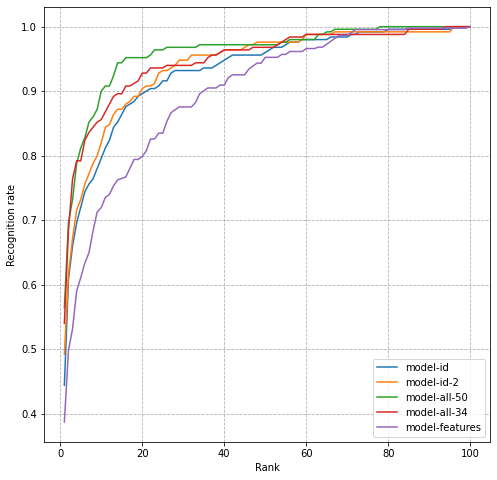

In [10]:
# import matplotlib.pyplot as plt
# import numpy as np

# topk_id = [0.444, 0.608, 0.66, 0.696, 0.72, 0.744, 0.756, 0.764, 0.78, 0.796, 0.812, 0.824, 0.844, 0.852, 0.864, 0.876, 0.88, 0.884, 0.892, 0.896, 0.9, 0.904, 0.904, 0.908, 0.916, 0.916, 0.928, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.932, 0.936, 0.936, 0.936, 0.94, 0.944, 0.948, 0.952, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.96, 0.964, 0.968, 0.968, 0.968, 0.972, 0.976, 0.976, 0.976, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.984, 0.984, 0.984, 0.984, 0.984, 0.988, 0.988, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0]
# topk_id_batch2 = [0.492, 0.616, 0.672, 0.716, 0.732, 0.756, 0.772, 0.788, 0.8, 0.82, 0.844, 0.848, 0.864, 0.872, 0.872, 0.88, 0.884, 0.892, 0.892, 0.904, 0.908, 0.908, 0.912, 0.928, 0.932, 0.932, 0.936, 0.94, 0.948, 0.948, 0.948, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.956, 0.96, 0.964, 0.964, 0.964, 0.964, 0.964, 0.968, 0.972, 0.972, 0.976, 0.976, 0.976, 0.976, 0.976, 0.976, 0.976, 0.976, 0.976, 0.976, 0.976, 0.98, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 0.992, 1.0, 1.0, 1.0, 1.0, 1.0]
# topk_all = [0.564, 0.696, 0.732, 0.788, 0.812, 0.828, 0.852, 0.86, 0.872, 0.9, 0.908, 0.908, 0.924, 0.944, 0.944, 0.952, 0.952, 0.952, 0.952, 0.952, 0.952, 0.956, 0.964, 0.964, 0.964, 0.968, 0.968, 0.968, 0.968, 0.968, 0.968, 0.968, 0.968, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.972, 0.976, 0.976, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98, 0.988, 0.988, 0.992, 0.992, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# topk_all34 = [0.54, 0.684, 0.764, 0.792, 0.792, 0.824, 0.836, 0.844, 0.852, 0.856, 0.868, 0.88, 0.892, 0.896, 0.896, 0.908, 0.908, 0.912, 0.916, 0.928, 0.928, 0.936, 0.936, 0.936, 0.936, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.94, 0.944, 0.944, 0.944, 0.952, 0.956, 0.956, 0.96, 0.964, 0.964, 0.964, 0.964, 0.964, 0.964, 0.964, 0.968, 0.968, 0.968, 0.968, 0.968, 0.968, 0.972, 0.976, 0.98, 0.984, 0.984, 0.984, 0.984, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.988, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 0.996, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
# topk_ft = [0.38687782805429866, 0.497737556561086, 0.5316742081447964, 0.5904977375565611, 0.6108597285067874, 0.6334841628959276, 0.6493212669683258, 0.6832579185520362, 0.7126696832579186, 0.7194570135746606, 0.7352941176470589, 0.7398190045248869, 0.753393665158371, 0.7624434389140271, 0.7647058823529411, 0.7669683257918553, 0.7805429864253394, 0.7941176470588235, 0.7941176470588235, 0.7986425339366516, 0.8076923076923077, 0.8257918552036199, 0.8257918552036199, 0.834841628959276, 0.834841628959276, 0.8529411764705882, 0.8665158371040724, 0.8710407239819005, 0.8755656108597285, 0.8755656108597285, 0.8755656108597285, 0.8755656108597285, 0.8823529411764706, 0.8959276018099548, 0.9004524886877828, 0.9049773755656109, 0.9049773755656109, 0.9049773755656109, 0.9095022624434389, 0.9095022624434389, 0.920814479638009, 0.9253393665158371, 0.9253393665158371, 0.9253393665158371, 0.9253393665158371, 0.9343891402714932, 0.9389140271493213, 0.9434389140271493, 0.9434389140271493, 0.9524886877828054, 0.9524886877828054, 0.9524886877828054, 0.9524886877828054, 0.9570135746606335, 0.9570135746606335, 0.9615384615384616, 0.9615384615384616, 0.9615384615384616, 0.9615384615384616, 0.9660633484162896, 0.9660633484162896, 0.9660633484162896, 0.9683257918552036, 0.9683257918552036, 0.9728506787330317, 0.9773755656108597, 0.9819004524886877, 0.9864253393665159, 0.9864253393665159, 0.9864253393665159, 0.9909502262443439, 0.995475113122172, 0.995475113122172, 0.995475113122172, 0.995475113122172, 0.995475113122172, 0.995475113122172, 0.995475113122172, 0.995475113122172, 0.995475113122172, 0.995475113122172, 0.995475113122172, 0.995475113122172, 0.995475113122172, 0.997737556561086, 0.997737556561086, 0.997737556561086, 0.997737556561086, 0.997737556561086, 0.997737556561086, 0.997737556561086, 0.997737556561086, 0.997737556561086, 0.997737556561086, 0.997737556561086, 0.997737556561086, 0.997737556561086, 0.997737556561086, 0.997737556561086, 1.0]

# plt.figure(figsize=(8, 8))
# plt.plot(list(range(1,101)), topk_id, label="model-id")
# plt.plot(list(range(1,101)), topk_id_batch2, label="model-id-2")
# plt.plot(list(range(1,101)), topk_all, label="model-all-50")
# plt.plot(list(range(1,101)), topk_all34, label="model-all-34")
# plt.plot(list(range(1,101)), topk_ft, label="model-features")
# plt.xlabel("Rank")
# plt.ylabel("Recognition rate")
# plt.legend(loc="lower right")
# plt.grid(True, linestyle='--')
# plt.savefig("/content/drive/MyDrive/plot.png", bbox_inches='tight')